In [17]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

### １．雨量数据

In [5]:
precipitation = pd.read_excel('XAJ_data_demo.xlsx', header=None, index_col=0)

precipitation.columns = ['flood_precip'] # 设置列名称

precipitation.index = precipitation.index.set_names(['flood_date']) # 设置index名字
precipitation[:4]

,flood_precip
flood_date,
2018-08-06 08:00:00,0.0
2018-08-06 09:00:00,0.0
2018-08-06 10:00:00,0.0
2018-08-06 11:00:00,0.0


### ２．流量数据整理

In [22]:
discharge_1 = pd.read_excel('discharge_demo.xls', index_col='TM')

In [6]:
discharge = pd.read_excel('discharge_demo.xls', index_col='TM')
# 按每５分钟重采样并对NaN数据进行前向填充
discharge = discharge.resample('5min').asfreq().fillna(method='ffill')
discharge = discharge.resample('h').asfreq()  # 取整点数据
discharge[:4]

,Q
TM,
2018-08-06 08:00:00,757.486
2018-08-06 09:00:00,744.343
2018-08-06 10:00:00,720.686
2018-08-06 11:00:00,710.171


### ３．洪峰选取

In [37]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [24]:
runoff = discharge['20180807 03:00': '20180807 18:00']

In [25]:
# 获取头尾两个流量
temp = runoff.drop(runoff.index[1:runoff.shape[0]-1])
# 生成基流
discharge_basic = temp.resample('h').interpolate(method='linear')

In [38]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2 entries, 2018-08-07 03:00:00 to 2018-08-07 18:00:00
Data columns (total 1 columns):
Q    2 non-null float64
dtypes: float64(1)
memory usage: 112.0 bytes


In [9]:
import matplotlib.pyplot as plt

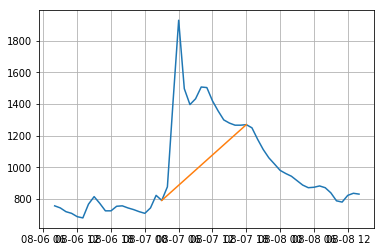

In [10]:
plt.plot(discharge.index, discharge.values)
plt.plot(discharge_basic.index, discharge_basic.values)
plt.grid(True)
plt.show()

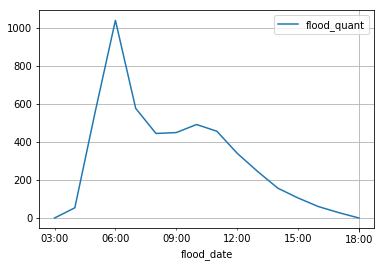

In [11]:
flood = runoff - discharge_basic
flood.columns = ['flood_quant']
flood.index = flood.index.set_names('flood_date')
flood.plot(grid=True)

### 4. 合并流量和雨量

In [12]:
flood_p = pd.merge(precipitation, flood, how='left', left_index=True, right_index=True).fillna(0)
# flood_p.plot(grid=True)

flood_p['flood_date'] = flood_p.index
flood_p['flood_id'] = '20180807'
flood_p['flood_evapor'] = 0
flood_p.reset_index(drop=True, inplace=True)
flood_p = flood_p[['flood_id', 'flood_date', 'flood_precip', 'flood_quant', 'flood_evapor']]
flood_p['flood_quant'] = flood_p['flood_quant'].map('{:.1f}'.format)

In [13]:
pre_rain = flood_p[:11]
pre_rain[:4]

pre_rain.drop(columns='flood_quant', inplace=True)
pre_rain.columns = ['flood_id', 'day_date', 'day_precip', 'day_evapor']
pre_rain.to_csv('pre_rain.txt', sep='\t', index=None)
pre_rain[:4]

/home/yasin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,flood_id,day_date,day_precip,day_evapor
0,20180807,2018-08-06 08:00:00,0.0,0
1,20180807,2018-08-06 09:00:00,0.0,0
2,20180807,2018-08-06 10:00:00,0.0,0
3,20180807,2018-08-06 11:00:00,0.0,0


In [14]:
flood_p = flood_p[11:]
flood_p.to_csv('flood.txt', sep='\t', index=None)

In [18]:
print('pre_rain.shape: {}\nflood_p.shape: {}'.format(pre_rain.shape, flood_p.shape))

pre_rain.shape: (11, 4)
flood_p.shape: (44, 5)


In [19]:
import pickle

#### 可视化验证数据

In [20]:
with open('simulated_flow.pickle', 'rb') as f:
    simulated_flow = pickle.load(f)

flood_p['simulated_flow'] = simulated_flow[0]


flood_p['flood_quant'] = flood_p['flood_quant'].astype(float)
flood_p['simulated_flow'] = flood_p['simulated_flow'].astype(float)

flood_p = flood_p.round({'flood_quant': 1, 'simulated_flow': 1})
flood_p[:3]

,flood_id,flood_date,flood_precip,flood_quant,flood_evapor,simulated_flow
11,20180807,2018-08-06 19:00:00,0.0,0.0,0,0.0
12,20180807,2018-08-06 20:00:00,0.0,0.0,0,0.0
13,20180807,2018-08-06 21:00:00,0.5,0.0,0,0.0


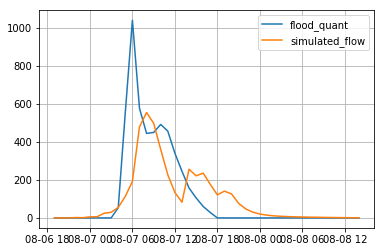

In [21]:
plt.plot(flood_p['flood_date'], flood_p['flood_quant'])
plt.plot(flood_p['flood_date'], flood_p['simulated_flow'])
plt.legend()
plt.grid(True)
plt.show()

In [310]:
flood_p

,flood_id,flood_date,flood_precip,flood_quant,flood_evapor,simulated_flow
11,20180807,2018-08-06 19:00:00,0.0,0.0,0,0.0
12,20180807,2018-08-06 20:00:00,0.0,0.0,0,0.0
13,20180807,2018-08-06 21:00:00,0.5,0.0,0,0.0
14,20180807,2018-08-06 22:00:00,0.0,0.0,0,2.0
15,20180807,2018-08-06 23:00:00,1.2,0.0,0,1.2
16,20180807,2018-08-07 00:00:00,0.7,0.0,0,5.5
17,20180807,2018-08-07 01:00:00,7.2,0.0,0,6.2
18,20180807,2018-08-07 02:00:00,3.4,0.0,0,24.6
19,20180807,2018-08-07 03:00:00,15.6,0.0,0,29.7
20,20180807,2018-08-07 04:00:00,36.9,53.8,0,55.5


No handles with labels found to put in legend.


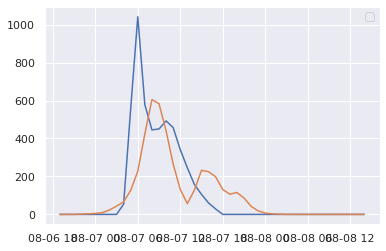

In [18]:
flood = pd.read_csv('flood.txt', sep='\t', parse_dates=['flood_date'])

with open('simulated_flow.pickle', 'rb') as f:
    simulated_flow = pickle.load(f)

flood['simulate_flow'] = simulated_flow[0]

plt.plot(flood['flood_date'], flood['flood_quant'])
plt.plot(flood.flood_date, flood.simulate_flow)
plt.legend()
plt.show()

No handles with labels found to put in legend.


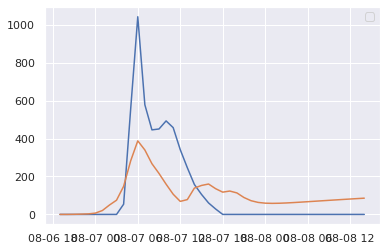

In [30]:
flood = pd.read_csv('flood.txt', sep='\t', parse_dates=['flood_date'])

with open('simulated_flow.pickle', 'rb') as f:
    simulated_flow = pickle.load(f)

flood['simulate_flow'] = simulated_flow[0]

plt.plot(flood['flood_date'], flood['flood_quant'])
plt.plot(flood.flood_date, flood.simulate_flow)
plt.legend()
plt.show()

No handles with labels found to put in legend.


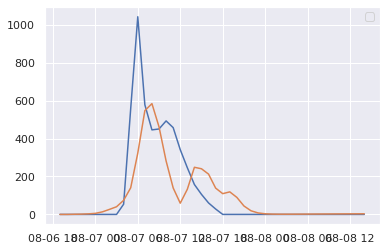

In [36]:
flood = pd.read_csv('flood.txt', sep='\t', parse_dates=['flood_date'])

with open('simulated_flow.pickle', 'rb') as f:
    simulated_flow = pickle.load(f)

flood['simulate_flow'] = simulated_flow[0]

plt.plot(flood['flood_date'], flood['flood_quant'])
plt.plot(flood.flood_date, flood.simulate_flow)
plt.legend()
plt.show()

### 4. 参数率定

In [32]:
with open('optimal_params', 'rb') as f:
    optimal_params = pickle.load(f)

with open('xaj_params.pickle', 'rb') as f:
    xaj_params_1 = pickle.load(f)

In [33]:
optimal_params[0]

[0.9066705795725403,
 12.564727056934904,
 68.66895657291167,
 0.19740372215321428,
 137.196361710203,
 0.3164611864485325,
 0.01071852837428263,
 1.231273275649647,
 1.1120431860010427,
 0.7996515574112859,
 0.9922475149215669,
 0.8210713682031088,
 0.3165578672418067,
 0.7658281632037084,
 0.05534309646128027]

In [35]:
xaj_params_1

K         0.477
WUM      14.135
WLM      89.453
C         0.131
WM      142.912
B         0.161
IMP       0.025
SM       28.736
EX        1.413
KSS       0.023
KKSS      0.097
KKG       0.987
CR        0.544
L         0.154
XE        0.180
KE        1.001
dtype: float64

In [301]:
x1[:15] = optimal_params[0]
x1.round(3)

K         1.261
WUM      12.644
WLM      65.948
C         0.173
WM      190.880
B         0.354
IMP       0.038
SM        1.156
EX        1.285
KSS       0.474
KKSS      0.850
KKG       0.756
CR        0.516
L         0.942
XE        0.310
KE        1.001
dtype: float64

In [288]:
xaj_params

K         0.998
WUM      27.764
WLM      84.393
C         0.200
WM      182.515
B         0.400
IMP       0.040
SM       51.634
EX        1.002
KSS       0.379
KKSS      0.986
KKG       0.284
CR        0.766
L         1.791
XE        0.029
KE        1.001
dtype: float64